In [1]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.mixture import GaussianMixture
from sklearn.svm import  SVC
import math
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
%matplotlib inline

In [2]:
PATHDATA = '../data/audiosData.csv'
df = pd.read_csv(PATHDATA, header = None)
data = df.values #Convertimos en un  numpy array

## Dividir el dataset usando GroupShuffleSplit


In [3]:
data.shape

(5200, 164)

In [4]:
X = data[:,0:-2]
Y = data[:,-1]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-2:-1]


Tamaño dataSet (5200, 162)




In [5]:
groups_count = np.unique(groups,return_counts=True)
np.max(groups_count[1])


29

In [6]:
groups

array([[ 13.],
       [ 15.],
       [ 15.],
       ...,
       [784.],
       [784.],
       [784.]])

In [7]:

def build_model(model, parameters, folds, train_size, X,Y):
  acc_scorer = make_scorer(accuracy_score)
  recalls = make_scorer(recall_score,average='micro')##buscar por que micro
  precision = make_scorer(precision_score,average='micro')
  f1 = make_scorer(f1_score,average='micro')
  scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
  gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
  model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups))
  model.fit(X,Y)
  return model 

In [8]:
def get_data_frame_results(dfRF,  args = ['mean_test_recalls',
                                        'std_test_recalls',
                                        'rank_test_recalls',
                                        'mean_train_recalls',
                                        'std_train_recalls',
                                        'mean_train_f1',
                                        'std_train_f1',
                                        'mean_test_Accuracy',
                                        'std_test_Accuracy',
                                        'rank_test_Accuracy',
                                        'std_train_Accuracy',
                                        'mean_train_Accuracy',
                                        'mean_fit_time',
                                        'std_fit_time',
                                        'mean_score_time',
                                        'std_score_time',
                                        'params'
          ]):



  data = {}

  for arg in args:
    data.update({arg: dfRF[arg]})
    
  # Data frame
  df_results = pd.DataFrame(data=data)
  return df_results

## learning_curve

In [9]:
def learning_curve(model,parameters,folds, X,Y, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy'):
    """
    Parameters
    ----------
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    std_train= []
    std_val=[]
    bests_params=[]

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(.1, .9, 5)

    # for each one of those training set sizes
    for i in training_set_sizes:

        model_trained = build_model(model, parameters, folds, i, X,Y)
        
        #Metrics, params 
        best_params = model_trained.cv_results_['params'][model_trained.best_index_]
        
        EfficiencyVal= model_trained.cv_results_['mean_test_Accuracy'][model_trained.best_index_]
        EfficiencyTrain=model_trained.cv_results_['mean_train_Accuracy'][model_trained.best_index_]
        stdTrain=model_trained.cv_results_['std_train_Accuracy'][model_trained.best_index_]
        stdVal=model_trained.cv_results_['std_test_Accuracy'][model_trained.best_index_]

        # store the scores in their respective lists
        train_score.append(EfficiencyTrain)
        val_score.append(EfficiencyVal)
        std_train.append(stdTrain)
        std_val.append(stdVal)
        bests_params.append(best_params)
    
    train_score =np.array(train_score)
    val_score =np.array(val_score)
    std_train =np.array(std_train)
    std_val =np.array(std_val)


    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')
    
    ax.fill_between(training_set_sizes,train_score+std_train,train_score-std_train,facecolor='gold',alpha=0.5)
    ax.fill_between(training_set_sizes,val_score+std_val,val_score-std_val,facecolor='steelblue',alpha=0.5)

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['Train set', 'Test set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)
    df_split_params = pd.DataFrame(list(zip(training_set_sizes, bests_params)),columns =['Train_Size', 'Params'])
    return df_split_params
    #y_formatter = FuncFormatter(percentages)
    #ax.yaxis.set_major_formatter(y_formatter)

    #x_formatter = FuncFormatter(numbers)
    #ax.xaxis.set_major_formatter(x_formatter)

  

# Leaning Curve GMM

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The def

,Params
Train_Size,
0.1,"{'covariance_type': 'tied', 'n_components': 3}"
0.3,"{'covariance_type': 'tied', 'n_components': 2}"
0.5,"{'covariance_type': 'full', 'n_components': 2}"
0.7,"{'covariance_type': 'full', 'n_components': 4}"
0.9,"{'covariance_type': 'spherical', 'n_components..."


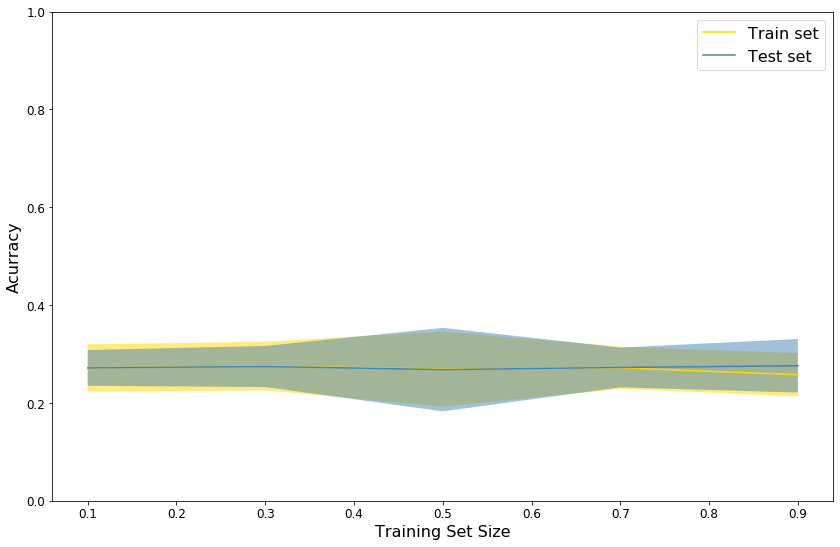

In [15]:
parameters ={'n_components' : [1,2,3,4,5,6,7,8,9,10,13,15,17,19,21],'covariance_type': ['tied','full','spherical','diag']}
GMM =GaussianMixture()#Configurar el modelo

df_split_params =learning_curve(GMM,parameters,15, X,Y)
df_split_params.set_index('Train_Size', inplace=True)
df_split_params

In [0]:
df_results = get_data_frame_results(GMM_Trained.cv_results_)

In [0]:
df_results

,mean_test_recalls,std_test_recalls,rank_test_recalls,mean_train_recalls,std_train_recalls,mean_train_f1,std_train_f1,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,std_train_Accuracy,mean_train_Accuracy,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,0.252181,0.009818,2,0.248566,0.006581,0.248566,0.006581,0.252181,0.009818,2,0.006581,0.248566,0.131018,0.017676,0.049956,0.001413,"{'covariance_type': 'tied', 'n_components': 1}"
1,0.286431,0.065322,1,0.287650,0.065415,0.287650,0.065415,0.286431,0.065322,1,0.065415,0.287650,1.154441,0.459392,0.089416,0.010240,"{'covariance_type': 'tied', 'n_components': 2}"


# Leaning Curve SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

,Params
Train_Size,
0.1,"{'C': 1, 'degree': 1, 'kernel': 'poly'}"
0.3,"{'C': 1, 'degree': 1, 'kernel': 'poly'}"
0.5,"{'C': 1, 'degree': 1, 'kernel': 'poly'}"
0.7,"{'C': 1, 'degree': 1, 'kernel': 'poly'}"
0.9,"{'C': 1, 'degree': 1, 'kernel': 'poly'}"


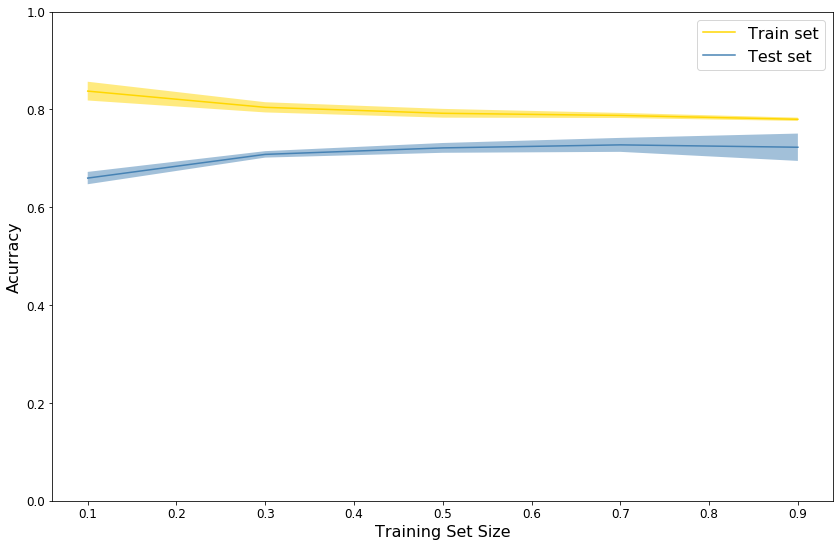

In [10]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-1],'C': [1]},
              {'kernel': ['linear'], 'C': [1]},
              {'kernel':['poly'],'C': [1],'degree':[1]}
             ]
SVMC = SVC()

df_split_params =learning_curve(SVMC,parameters,15, X,Y)
df_split_params.set_index('Train_Size', inplace=True)
df_split_params

In [ ]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2,1e-3],'C': [1,10,100]},
              {'kernel': ['linear'], 'C': [1,10,100]},
              {'kernel':['poly'],'C': [1,10,100],'degree':[1,2,3]}
             ]
SVMC = SVC()

df_split_params =learning_curve(SVMC,parameters,15, X,Y)
df_split_params.set_index('Train_Size', inplace=True)
df_split_params

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
